# Install Dependencies

In [ ]:
#!pip install stable-baselines3 gym-anytrading gym
#!pip install finta
#!pip install quantstats

In [1]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3 import A2C

#Quant Finance
from finta import TA
import quantstats as qs

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Source Trading Data

In [2]:
#Get Key for Alphavantage API
with open('key.txt', 'r') as f:
    key = f.readline()

In [3]:
#Download 3 months of data (Alphavantage only provides 1 month per call)
month_1 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month1&apikey={key}&datatype=csv'
month_2 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month2&apikey={key}&datatype=csv'
month_3 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month3&apikey={key}&datatype=csv'

#Grab the Data as CSV
csv_1 = pd.read_csv(month_1)
csv_2 = pd.read_csv(month_2)
csv_3 = pd.read_csv(month_3)

#Put it into a DataFrame
data_1 = pd.DataFrame(csv_1)
data_2 = pd.DataFrame(csv_2)
data_3 = pd.DataFrame(csv_3)

#Append the three months into one Dataframe
data = data_1.append([data_2, data_3])

data.head(3)

C:\Users\evere\AppData\Local\Temp\ipykernel_24812\712993438.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_1.append([data_2, data_3])


,time,open,high,low,close,volume
0,2023-01-25 20:00:00,142.11,142.15,142.01,142.06,17601
1,2023-01-25 19:55:00,142.07,142.10,142.05,142.08,8001
2,2023-01-25 19:50:00,142.04,142.06,142.03,142.05,7489


In [4]:
#Change the Time to proper type and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.head()

,open,high,low,close,volume
time,,,,,
2023-01-25 20:00:00,142.11,142.15,142.01,142.06,17601
2023-01-25 19:55:00,142.07,142.10,142.05,142.08,8001
2023-01-25 19:50:00,142.04,142.06,142.03,142.05,7489
2023-01-25 19:45:00,142.10,142.10,142.04,142.05,4549
2023-01-25 19:40:00,142.04,142.07,142.04,142.07,4906


In [5]:
#Set the values so the earliest time is first and the latest is last in the dataframe
data.sort_values('time', ascending=True, inplace=True)
data.head()

,open,high,low,close,volume
time,,,,,
2022-10-28 04:05:00,143.270445,144.676328,143.270445,144.556679,26040
2022-10-28 04:10:00,144.526766,145.085131,144.526766,144.875744,30759
2022-10-28 04:15:00,144.945540,145.154927,144.945540,145.045248,22412
2022-10-28 04:20:00,145.005365,145.045248,144.975452,144.975452,11349
2022-10-28 04:25:00,144.985423,145.304489,144.985423,145.304489,9167


In [6]:
#Title the columns for gym formatting reasons
data = data.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

In [7]:
data.shape

(11237, 5)

In [8]:
#Data tyeps neet to be numbers not objects
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

# Add Custom Indicators

### SMA RSI OBV

In [9]:
#Create columns for technical indicators & add them to the dataframe
data['RSI'] = TA.RSI(data,16)
data['SMA'] = TA.SMA(data)
data['OBV'] = TA.OBV(data)
data.fillna(0, inplace=True)

# Build Gym

In [10]:
#Create a function to properly format data frame to be passed through environment
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low','Open','High','Volume','RSI','SMA','OBV',]].to_numpy()[start:end]
    return prices, signal_features

In [11]:
data.head()

,Open,High,Low,Close,Volume,RSI,SMA,OBV
time,,,,,,,,
2022-10-28 04:05:00,143.270445,144.676328,143.270445,144.556679,26040,0.000000,0.0,0.0
2022-10-28 04:10:00,144.526766,145.085131,144.526766,144.875744,30759,100.000000,0.0,30759.0
2022-10-28 04:15:00,144.945540,145.154927,144.945540,145.045248,22412,100.000000,0.0,53171.0
2022-10-28 04:20:00,145.005365,145.045248,144.975452,144.975452,11349,86.291310,0.0,41822.0
2022-10-28 04:25:00,144.985423,145.304489,144.985423,145.304489,9167,91.885234,0.0,50989.0


In [17]:
#Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):
    _process_data = signals
    
#Initialize an environment setting the window size and train data
env2 = MyCustomEnv(df=data, window_size=100, frame_bound=(100, 9000))

In [18]:
#Create a Dummy Vector of our environment
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

# Train Agent

In [19]:
# Create log dir to save path to store our callback and model
log_dir = "reinforcement_learning/tmp/"
save_path = os.path.join('reinforcement_learning','tmp')

In [20]:
#Stop training when the model reaches a stable training threshold
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)

#Check training & evaluate performance unitl threshold has been met
eval_callback = EvalCallback(env,
                            callback_on_new_best=stop_callback,
                            eval_freq=10000,
                            best_model_save_path=save_path,
                            verbose=1)

In [21]:
#initialize our model and train
actor_critic = A2C('MlpPolicy', env, verbose=1) 
actor_critic.learn(total_timesteps=1000000, callback=eval_callback)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 942      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | -13.9    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.42     |
|    value_loss         | 0.458    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1035     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.441   |
|    explained_variance | -68.2    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.00262 |
|    value_loss      

------------------------------------
| time/                 |          |
|    fps                | 1048     |
|    iterations         | 1700     |
|    time_elapsed       | 8        |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -0.298   |
|    explained_variance | -104     |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | -0.0196  |
|    value_loss         | 0.00186  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1034     |
|    iterations         | 1800     |
|    time_elapsed       | 8        |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -0.451   |
|    explained_variance | -7.92    |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | -0.00539 |
|    value_loss         | 0.000457 |
-

C:\Users\evere\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-12.94 +/- 0.00
Episode length: 8899.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 8.9e+03  |
|    mean_reward        | -12.9    |
| time/                 |          |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -0.672   |
|    explained_variance | -0.446   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | -0.307   |
|    value_loss         | 0.218    |
------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 478   |
|    iterations      | 2000  |
|    time_elapsed    | 20    |
|    total_timesteps | 10000 |
------------------------------
------------------------------------
| time/                 |          |
|    fps                | 493      |
|    iterations         | 2100     |
|    

------------------------------------
| time/                 |          |
|    fps                | 593      |
|    iterations         | 3600     |
|    time_elapsed       | 30       |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -0.132   |
|    explained_variance | -2.23    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3599     |
|    policy_loss        | -0.609   |
|    value_loss         | 0.761    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 598      |
|    iterations         | 3700     |
|    time_elapsed       | 30       |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -0.102   |
|    explained_variance | -887     |
|    learning_rate      | 0.0007   |
|    n_updates          | 3699     |
|    policy_loss        | 0.000162 |
|    value_loss         | 0.00114  |
-

-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 5100      |
|    time_elapsed       | 52        |
|    total_timesteps    | 25500     |
| train/                |           |
|    entropy_loss       | -0.0377   |
|    explained_variance | -563      |
|    learning_rate      | 0.0007    |
|    n_updates          | 5099      |
|    policy_loss        | -0.000197 |
|    value_loss         | 0.00102   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 494       |
|    iterations         | 5200      |
|    time_elapsed       | 52        |
|    total_timesteps    | 26000     |
| train/                |           |
|    entropy_loss       | -0.0522   |
|    explained_variance | -1.91     |
|    learning_rate      | 0.0007    |
|    n_updates          | 5199      |
|    policy_loss        | -2.47e-05 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 450       |
|    iterations         | 6600      |
|    time_elapsed       | 73        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -0.0255   |
|    explained_variance | -2.59e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | -2.81e-06 |
|    value_loss         | 7.72e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 454       |
|    iterations         | 6700      |
|    time_elapsed       | 73        |
|    total_timesteps    | 33500     |
| train/                |           |
|    entropy_loss       | -0.0262   |
|    explained_variance | -171      |
|    learning_rate      | 0.0007    |
|    n_updates          | 6699      |
|    policy_loss        | -8.63e-06 |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 437      |
|    iterations         | 8200     |
|    time_elapsed       | 93       |
|    total_timesteps    | 41000    |
| train/                |          |
|    entropy_loss       | -0.00203 |
|    explained_variance | -561     |
|    learning_rate      | 0.0007   |
|    n_updates          | 8199     |
|    policy_loss        | 1.61e-07 |
|    value_loss         | 1.31e-05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 440       |
|    iterations         | 8300      |
|    time_elapsed       | 94        |
|    total_timesteps    | 41500     |
| train/                |           |
|    entropy_loss       | -0.00199  |
|    explained_variance | -2.55e+07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 8299      |
|    policy_loss        | -2.02e-07 |
|    value_loss         | 

------------------------------------
| time/                 |          |
|    fps                | 477      |
|    iterations         | 9800     |
|    time_elapsed       | 102      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -0.00122 |
|    explained_variance | -8.73    |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 1.98e-07 |
|    value_loss         | 3.95e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 480      |
|    iterations         | 9900     |
|    time_elapsed       | 103      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -0.00118 |
|    explained_variance | -216     |
|    learning_rate      | 0.0007   |
|    n_updates          | 9899     |
|    policy_loss        | 7.87e-08 |
|    value_loss         | 2.24e-06 |
-

-------------------------------------
| time/                 |           |
|    fps                | 458       |
|    iterations         | 11300     |
|    time_elapsed       | 123       |
|    total_timesteps    | 56500     |
| train/                |           |
|    entropy_loss       | -0.000861 |
|    explained_variance | -280      |
|    learning_rate      | 0.0007    |
|    n_updates          | 11299     |
|    policy_loss        | -7.51e-07 |
|    value_loss         | 0.000184  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 460       |
|    iterations         | 11400     |
|    time_elapsed       | 123       |
|    total_timesteps    | 57000     |
| train/                |           |
|    entropy_loss       | -0.000801 |
|    explained_variance | -78.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 11399     |
|    policy_loss        | 4.78e-07  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 441       |
|    iterations         | 12800     |
|    time_elapsed       | 144       |
|    total_timesteps    | 64000     |
| train/                |           |
|    entropy_loss       | -0.000459 |
|    explained_variance | -25.1     |
|    learning_rate      | 0.0007    |
|    n_updates          | 12799     |
|    policy_loss        | -3.5e-08  |
|    value_loss         | 5.1e-06   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 442       |
|    iterations         | 12900     |
|    time_elapsed       | 145       |
|    total_timesteps    | 64500     |
| train/                |           |
|    entropy_loss       | -0.000462 |
|    explained_variance | -129      |
|    learning_rate      | 0.0007    |
|    n_updates          | 12899     |
|    policy_loss        | 3.19e-07  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 423       |
|    iterations         | 14300     |
|    time_elapsed       | 168       |
|    total_timesteps    | 71500     |
| train/                |           |
|    entropy_loss       | -0.000793 |
|    explained_variance | -291      |
|    learning_rate      | 0.0007    |
|    n_updates          | 14299     |
|    policy_loss        | 6.77e-08  |
|    value_loss         | 1.32e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 14400     |
|    time_elapsed       | 169       |
|    total_timesteps    | 72000     |
| train/                |           |
|    entropy_loss       | -0.000596 |
|    explained_variance | -24.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 14399     |
|    policy_loss        | 1.12e-07  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 452       |
|    iterations         | 15900     |
|    time_elapsed       | 175       |
|    total_timesteps    | 79500     |
| train/                |           |
|    entropy_loss       | -0.000244 |
|    explained_variance | -1.16e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 15899     |
|    policy_loss        | -3.17e-08 |
|    value_loss         | 3.14e-06  |
-------------------------------------
Eval num_timesteps=80000, episode_reward=-11.17 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -11.2     |
| time/                 |           |
|    total_timesteps    | 80000     |
| train/                |           |
|    entropy_loss       | -0.000598 |
|    explained_variance | -162      |
|    learning_rate      | 0.0007    

------------------------------------
| time/                 |          |
|    fps                | 447      |
|    iterations         | 17400    |
|    time_elapsed       | 194      |
|    total_timesteps    | 87000    |
| train/                |          |
|    entropy_loss       | -0.00017 |
|    explained_variance | -30      |
|    learning_rate      | 0.0007   |
|    n_updates          | 17399    |
|    policy_loss        | 1.25e-07 |
|    value_loss         | 8.15e-05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 448       |
|    iterations         | 17500     |
|    time_elapsed       | 195       |
|    total_timesteps    | 87500     |
| train/                |           |
|    entropy_loss       | -0.000176 |
|    explained_variance | -10.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 17499     |
|    policy_loss        | -1.54e-09 |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 434       |
|    iterations         | 18900     |
|    time_elapsed       | 217       |
|    total_timesteps    | 94500     |
| train/                |           |
|    entropy_loss       | -5.77e-05 |
|    explained_variance | -435      |
|    learning_rate      | 0.0007    |
|    n_updates          | 18899     |
|    policy_loss        | 1.87e-08  |
|    value_loss         | 3.47e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 435       |
|    iterations         | 19000     |
|    time_elapsed       | 218       |
|    total_timesteps    | 95000     |
| train/                |           |
|    entropy_loss       | -6.22e-05 |
|    explained_variance | -233      |
|    learning_rate      | 0.0007    |
|    n_updates          | 18999     |
|    policy_loss        | -4.44e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 428       |
|    iterations         | 20400     |
|    time_elapsed       | 238       |
|    total_timesteps    | 102000    |
| train/                |           |
|    entropy_loss       | -4.89e-05 |
|    explained_variance | -183      |
|    learning_rate      | 0.0007    |
|    n_updates          | 20399     |
|    policy_loss        | 2e-08     |
|    value_loss         | 6.16e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 429       |
|    iterations         | 20500     |
|    time_elapsed       | 238       |
|    total_timesteps    | 102500    |
| train/                |           |
|    entropy_loss       | -5.15e-05 |
|    explained_variance | -67.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 20499     |
|    policy_loss        | 2.88e-08  |
|    value_l

Eval num_timesteps=110000, episode_reward=-11.39 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -11.4     |
| time/                 |           |
|    total_timesteps    | 110000    |
| train/                |           |
|    entropy_loss       | -9.21e-05 |
|    explained_variance | -327      |
|    learning_rate      | 0.0007    |
|    n_updates          | 21999     |
|    policy_loss        | -5.41e-08 |
|    value_loss         | 8.6e-05   |
-------------------------------------
-------------------------------
| time/              |        |
|    fps             | 417    |
|    iterations      | 22000  |
|    time_elapsed    | 263    |
|    total_timesteps | 110000 |
-------------------------------
------------------------------------
| time/                 |          |
|    fps                | 418      |
|    iterations         | 22100    |
|    

-------------------------------------
| time/                 |           |
|    fps                | 433       |
|    iterations         | 23500     |
|    time_elapsed       | 271       |
|    total_timesteps    | 117500    |
| train/                |           |
|    entropy_loss       | -2.12e-05 |
|    explained_variance | -3.6      |
|    learning_rate      | 0.0007    |
|    n_updates          | 23499     |
|    policy_loss        | -2.33e-09 |
|    value_loss         | 3.34e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 434       |
|    iterations         | 23600     |
|    time_elapsed       | 271       |
|    total_timesteps    | 118000    |
| train/                |           |
|    entropy_loss       | -2e-05    |
|    explained_variance | -75       |
|    learning_rate      | 0.0007    |
|    n_updates          | 23599     |
|    policy_loss        | -6.13e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 429       |
|    iterations         | 25000     |
|    time_elapsed       | 290       |
|    total_timesteps    | 125000    |
| train/                |           |
|    entropy_loss       | -2.33e-05 |
|    explained_variance | -640      |
|    learning_rate      | 0.0007    |
|    n_updates          | 24999     |
|    policy_loss        | -5.08e-08 |
|    value_loss         | 0.00111   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 430       |
|    iterations         | 25100     |
|    time_elapsed       | 291       |
|    total_timesteps    | 125500    |
| train/                |           |
|    entropy_loss       | -2.56e-05 |
|    explained_variance | -28.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 25099     |
|    policy_loss        | -1.52e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 26500     |
|    time_elapsed       | 314       |
|    total_timesteps    | 132500    |
| train/                |           |
|    entropy_loss       | -1.28e-05 |
|    explained_variance | -72.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 26499     |
|    policy_loss        | -8.73e-09 |
|    value_loss         | 0.000155  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 26600     |
|    time_elapsed       | 315       |
|    total_timesteps    | 133000    |
| train/                |           |
|    entropy_loss       | -1.47e-05 |
|    explained_variance | -38       |
|    learning_rate      | 0.0007    |
|    n_updates          | 26599     |
|    policy_loss        | 2.6e-09   |
|    value_l

-------------------------------
| time/              |        |
|    fps             | 415    |
|    iterations      | 28000  |
|    time_elapsed    | 336    |
|    total_timesteps | 140000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 28100     |
|    time_elapsed       | 337       |
|    total_timesteps    | 140500    |
| train/                |           |
|    entropy_loss       | -1.7e-05  |
|    explained_variance | -180      |
|    learning_rate      | 0.0007    |
|    n_updates          | 28099     |
|    policy_loss        | -1.35e-08 |
|    value_loss         | 0.000182  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 28200     |
|    time_elapsed       | 337       |
|    total_timesteps    | 141000    |
| train/        

-------------------------------------
| time/                 |           |
|    fps                | 432       |
|    iterations         | 29700     |
|    time_elapsed       | 343       |
|    total_timesteps    | 148500    |
| train/                |           |
|    entropy_loss       | -1.71e-05 |
|    explained_variance | -210      |
|    learning_rate      | 0.0007    |
|    n_updates          | 29699     |
|    policy_loss        | -2.58e-10 |
|    value_loss         | 5.67e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 433       |
|    iterations         | 29800     |
|    time_elapsed       | 343       |
|    total_timesteps    | 149000    |
| train/                |           |
|    entropy_loss       | -1.62e-05 |
|    explained_variance | -3.03e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 29799     |
|    policy_loss        | -6.63e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 428       |
|    iterations         | 31200     |
|    time_elapsed       | 364       |
|    total_timesteps    | 156000    |
| train/                |           |
|    entropy_loss       | -1.71e-05 |
|    explained_variance | -508      |
|    learning_rate      | 0.0007    |
|    n_updates          | 31199     |
|    policy_loss        | -2.26e-09 |
|    value_loss         | 6.08e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 429       |
|    iterations         | 31300     |
|    time_elapsed       | 364       |
|    total_timesteps    | 156500    |
| train/                |           |
|    entropy_loss       | -1.82e-05 |
|    explained_variance | -11.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 31299     |
|    policy_loss        | -1.04e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 32700     |
|    time_elapsed       | 385       |
|    total_timesteps    | 163500    |
| train/                |           |
|    entropy_loss       | -1.56e-05 |
|    explained_variance | -25.1     |
|    learning_rate      | 0.0007    |
|    n_updates          | 32699     |
|    policy_loss        | 3.53e-10  |
|    value_loss         | 1.88e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 32800     |
|    time_elapsed       | 386       |
|    total_timesteps    | 164000    |
| train/                |           |
|    entropy_loss       | -1.56e-05 |
|    explained_variance | -592      |
|    learning_rate      | 0.0007    |
|    n_updates          | 32799     |
|    policy_loss        | 2.9e-10   |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 34200     |
|    time_elapsed       | 407       |
|    total_timesteps    | 171000    |
| train/                |           |
|    entropy_loss       | -1.93e-05 |
|    explained_variance | -31.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 34199     |
|    policy_loss        | -1.36e-09 |
|    value_loss         | 8.21e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 34300     |
|    time_elapsed       | 408       |
|    total_timesteps    | 171500    |
| train/                |           |
|    entropy_loss       | -2.15e-05 |
|    explained_variance | -2.24e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 34299     |
|    policy_loss        | -4.7e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 427       |
|    iterations         | 35800     |
|    time_elapsed       | 418       |
|    total_timesteps    | 179000    |
| train/                |           |
|    entropy_loss       | -1.25e-05 |
|    explained_variance | -130      |
|    learning_rate      | 0.0007    |
|    n_updates          | 35799     |
|    policy_loss        | -5.53e-09 |
|    value_loss         | 6.62e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 428       |
|    iterations         | 35900     |
|    time_elapsed       | 419       |
|    total_timesteps    | 179500    |
| train/                |           |
|    entropy_loss       | -1.13e-05 |
|    explained_variance | -5.28     |
|    learning_rate      | 0.0007    |
|    n_updates          | 35899     |
|    policy_loss        | 1.04e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 37300     |
|    time_elapsed       | 439       |
|    total_timesteps    | 186500    |
| train/                |           |
|    entropy_loss       | -1.13e-05 |
|    explained_variance | -805      |
|    learning_rate      | 0.0007    |
|    n_updates          | 37299     |
|    policy_loss        | -2.09e-09 |
|    value_loss         | 4.67e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 37400     |
|    time_elapsed       | 440       |
|    total_timesteps    | 187000    |
| train/                |           |
|    entropy_loss       | -1.15e-05 |
|    explained_variance | -2.03e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 37399     |
|    policy_loss        | -1.86e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 38800     |
|    time_elapsed       | 457       |
|    total_timesteps    | 194000    |
| train/                |           |
|    entropy_loss       | -9.33e-06 |
|    explained_variance | -2.53e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 38799     |
|    policy_loss        | 2.38e-10  |
|    value_loss         | 3.52e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 38900     |
|    time_elapsed       | 457       |
|    total_timesteps    | 194500    |
| train/                |           |
|    entropy_loss       | -9.22e-06 |
|    explained_variance | -109      |
|    learning_rate      | 0.0007    |
|    n_updates          | 38899     |
|    policy_loss        | 7.56e-10  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 40300     |
|    time_elapsed       | 479       |
|    total_timesteps    | 201500    |
| train/                |           |
|    entropy_loss       | -1.75e-05 |
|    explained_variance | -124      |
|    learning_rate      | 0.0007    |
|    n_updates          | 40299     |
|    policy_loss        | -2.75e-10 |
|    value_loss         | 1.22e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 40400     |
|    time_elapsed       | 480       |
|    total_timesteps    | 202000    |
| train/                |           |
|    entropy_loss       | -8.46e-06 |
|    explained_variance | -189      |
|    learning_rate      | 0.0007    |
|    n_updates          | 40399     |
|    policy_loss        | 1.93e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 427       |
|    iterations         | 41900     |
|    time_elapsed       | 490       |
|    total_timesteps    | 209500    |
| train/                |           |
|    entropy_loss       | -8.3e-06  |
|    explained_variance | -1.09e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 41899     |
|    policy_loss        | 5.85e-10  |
|    value_loss         | 1.85e-06  |
-------------------------------------
Eval num_timesteps=210000, episode_reward=-11.52 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -11.5     |
| time/                 |           |
|    total_timesteps    | 210000    |
| train/                |           |
|    entropy_loss       | -1.45e-05 |
|    explained_variance | -2.24e+05 |
|    learning_rate      | 0.0007   

-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 43400     |
|    time_elapsed       | 511       |
|    total_timesteps    | 217000    |
| train/                |           |
|    entropy_loss       | -7.05e-06 |
|    explained_variance | -288      |
|    learning_rate      | 0.0007    |
|    n_updates          | 43399     |
|    policy_loss        | 1.54e-09  |
|    value_loss         | 1.93e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 43500     |
|    time_elapsed       | 511       |
|    total_timesteps    | 217500    |
| train/                |           |
|    entropy_loss       | -7.44e-06 |
|    explained_variance | -18.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 43499     |
|    policy_loss        | -8.82e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 44900     |
|    time_elapsed       | 532       |
|    total_timesteps    | 224500    |
| train/                |           |
|    entropy_loss       | -6.74e-06 |
|    explained_variance | -10.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 44899     |
|    policy_loss        | -1.75e-09 |
|    value_loss         | 1.61e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 45000     |
|    time_elapsed       | 532       |
|    total_timesteps    | 225000    |
| train/                |           |
|    entropy_loss       | -7.02e-06 |
|    explained_variance | -62.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 44999     |
|    policy_loss        | -3.47e-09 |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 419      |
|    iterations         | 46400    |
|    time_elapsed       | 552      |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -9.5e-06 |
|    explained_variance | -66      |
|    learning_rate      | 0.0007   |
|    n_updates          | 46399    |
|    policy_loss        | 3.74e-09 |
|    value_loss         | 6.44e-05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 46500     |
|    time_elapsed       | 552       |
|    total_timesteps    | 232500    |
| train/                |           |
|    entropy_loss       | -9.68e-06 |
|    explained_variance | -21.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 46499     |
|    policy_loss        | -3.07e-10 |
|    value_loss         | 

Eval num_timesteps=240000, episode_reward=-11.35 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -11.3     |
| time/                 |           |
|    total_timesteps    | 240000    |
| train/                |           |
|    entropy_loss       | -1.91e-05 |
|    explained_variance | -148      |
|    learning_rate      | 0.0007    |
|    n_updates          | 47999     |
|    policy_loss        | 1.29e-10  |
|    value_loss         | 9.42e-06  |
-------------------------------------
-------------------------------
| time/              |        |
|    fps             | 419    |
|    iterations      | 48000  |
|    time_elapsed    | 572    |
|    total_timesteps | 240000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 48100     |
|

------------------------------------
| time/                 |          |
|    fps                | 427      |
|    iterations         | 49500    |
|    time_elapsed       | 579      |
|    total_timesteps    | 247500   |
| train/                |          |
|    entropy_loss       | -9.3e-06 |
|    explained_variance | -32.6    |
|    learning_rate      | 0.0007   |
|    n_updates          | 49499    |
|    policy_loss        | 1.62e-10 |
|    value_loss         | 8.07e-05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 427       |
|    iterations         | 49600     |
|    time_elapsed       | 579       |
|    total_timesteps    | 248000    |
| train/                |           |
|    entropy_loss       | -8.72e-06 |
|    explained_variance | -678      |
|    learning_rate      | 0.0007    |
|    n_updates          | 49599     |
|    policy_loss        | 3.06e-10  |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 423       |
|    iterations         | 51000     |
|    time_elapsed       | 602       |
|    total_timesteps    | 255000    |
| train/                |           |
|    entropy_loss       | -5.28e-06 |
|    explained_variance | -3.56e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 50999     |
|    policy_loss        | -9.26e-10 |
|    value_loss         | 8.95e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 423       |
|    iterations         | 51100     |
|    time_elapsed       | 603       |
|    total_timesteps    | 255500    |
| train/                |           |
|    entropy_loss       | -5.89e-06 |
|    explained_variance | -7.94     |
|    learning_rate      | 0.0007    |
|    n_updates          | 51099     |
|    policy_loss        | 1.07e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 52500     |
|    time_elapsed       | 621       |
|    total_timesteps    | 262500    |
| train/                |           |
|    entropy_loss       | -6.89e-06 |
|    explained_variance | -1.96e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 52499     |
|    policy_loss        | -2.67e-09 |
|    value_loss         | 3.68e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 52600     |
|    time_elapsed       | 621       |
|    total_timesteps    | 263000    |
| train/                |           |
|    entropy_loss       | -8.04e-06 |
|    explained_variance | -453      |
|    learning_rate      | 0.0007    |
|    n_updates          | 52599     |
|    policy_loss        | 6.77e-10  |
|    value_l

-------------------------------
| time/              |        |
|    fps             | 421    |
|    iterations      | 54000  |
|    time_elapsed    | 640    |
|    total_timesteps | 270000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 54100     |
|    time_elapsed       | 641       |
|    total_timesteps    | 270500    |
| train/                |           |
|    entropy_loss       | -8.22e-06 |
|    explained_variance | -26.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 54099     |
|    policy_loss        | -3.42e-10 |
|    value_loss         | 1.99e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 54200     |
|    time_elapsed       | 642       |
|    total_timesteps    | 271000    |
| train/        

-------------------------------------
| time/                 |           |
|    fps                | 426       |
|    iterations         | 55600     |
|    time_elapsed       | 652       |
|    total_timesteps    | 278000    |
| train/                |           |
|    entropy_loss       | -6.96e-06 |
|    explained_variance | -89.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 55599     |
|    policy_loss        | -1.14e-09 |
|    value_loss         | 6.81e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 426       |
|    iterations         | 55700     |
|    time_elapsed       | 652       |
|    total_timesteps    | 278500    |
| train/                |           |
|    entropy_loss       | -7.36e-06 |
|    explained_variance | -926      |
|    learning_rate      | 0.0007    |
|    n_updates          | 55699     |
|    policy_loss        | -6.62e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 57100     |
|    time_elapsed       | 672       |
|    total_timesteps    | 285500    |
| train/                |           |
|    entropy_loss       | -7.82e-06 |
|    explained_variance | -7.6      |
|    learning_rate      | 0.0007    |
|    n_updates          | 57099     |
|    policy_loss        | 1.5e-09   |
|    value_loss         | 1.19e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 424       |
|    iterations         | 57200     |
|    time_elapsed       | 673       |
|    total_timesteps    | 286000    |
| train/                |           |
|    entropy_loss       | -7.39e-06 |
|    explained_variance | -1.64     |
|    learning_rate      | 0.0007    |
|    n_updates          | 57199     |
|    policy_loss        | 3.92e-10  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 58600     |
|    time_elapsed       | 698       |
|    total_timesteps    | 293000    |
| train/                |           |
|    entropy_loss       | -1.97e-05 |
|    explained_variance | -24.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 58599     |
|    policy_loss        | 8.29e-11  |
|    value_loss         | 1.23e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 58700     |
|    time_elapsed       | 698       |
|    total_timesteps    | 293500    |
| train/                |           |
|    entropy_loss       | -1.47e-05 |
|    explained_variance | -30.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 58699     |
|    policy_loss        | 2.25e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 60100     |
|    time_elapsed       | 718       |
|    total_timesteps    | 300500    |
| train/                |           |
|    entropy_loss       | -2.65e-05 |
|    explained_variance | -48.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 60099     |
|    policy_loss        | -1.58e-09 |
|    value_loss         | 1.07e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 60200     |
|    time_elapsed       | 718       |
|    total_timesteps    | 301000    |
| train/                |           |
|    entropy_loss       | -0.000134 |
|    explained_variance | -107      |
|    learning_rate      | 0.0007    |
|    n_updates          | 60199     |
|    policy_loss        | 1.09e-08  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 425       |
|    iterations         | 61700     |
|    time_elapsed       | 725       |
|    total_timesteps    | 308500    |
| train/                |           |
|    entropy_loss       | -4.67e-05 |
|    explained_variance | -1.71e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 61699     |
|    policy_loss        | -1.98e-09 |
|    value_loss         | 1.82e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 425       |
|    iterations         | 61800     |
|    time_elapsed       | 725       |
|    total_timesteps    | 309000    |
| train/                |           |
|    entropy_loss       | -3.87e-05 |
|    explained_variance | -0.222    |
|    learning_rate      | 0.0007    |
|    n_updates          | 61799     |
|    policy_loss        | 5.17e-08  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 63200     |
|    time_elapsed       | 751       |
|    total_timesteps    | 316000    |
| train/                |           |
|    entropy_loss       | -2.52e-05 |
|    explained_variance | -114      |
|    learning_rate      | 0.0007    |
|    n_updates          | 63199     |
|    policy_loss        | 4.03e-10  |
|    value_loss         | 1.47e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 63300     |
|    time_elapsed       | 752       |
|    total_timesteps    | 316500    |
| train/                |           |
|    entropy_loss       | -3.23e-05 |
|    explained_variance | -13.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 63299     |
|    policy_loss        | -1.06e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 64700     |
|    time_elapsed       | 774       |
|    total_timesteps    | 323500    |
| train/                |           |
|    entropy_loss       | -5.58e-05 |
|    explained_variance | -82.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 64699     |
|    policy_loss        | 3.23e-09  |
|    value_loss         | 1.04e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 64800     |
|    time_elapsed       | 774       |
|    total_timesteps    | 324000    |
| train/                |           |
|    entropy_loss       | -7.36e-05 |
|    explained_variance | -11.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 64799     |
|    policy_loss        | 8.46e-09  |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 415      |
|    iterations         | 66200    |
|    time_elapsed       | 796      |
|    total_timesteps    | 331000   |
| train/                |          |
|    entropy_loss       | -0.00142 |
|    explained_variance | -120     |
|    learning_rate      | 0.0007   |
|    n_updates          | 66199    |
|    policy_loss        | 6.37e-07 |
|    value_loss         | 2.07e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 416      |
|    iterations         | 66300    |
|    time_elapsed       | 796      |
|    total_timesteps    | 331500   |
| train/                |          |
|    entropy_loss       | -0.00096 |
|    explained_variance | -317     |
|    learning_rate      | 0.0007   |
|    n_updates          | 66299    |
|    policy_loss        | 6.63e-08 |
|    value_loss         | 4.82e-06 |
-

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 67800     |
|    time_elapsed       | 803       |
|    total_timesteps    | 339000    |
| train/                |           |
|    entropy_loss       | -0.000141 |
|    explained_variance | -2.36e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 67799     |
|    policy_loss        | -9.43e-08 |
|    value_loss         | 0.000168  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 67900     |
|    time_elapsed       | 803       |
|    total_timesteps    | 339500    |
| train/                |           |
|    entropy_loss       | -0.000255 |
|    explained_variance | -192      |
|    learning_rate      | 0.0007    |
|    n_updates          | 67899     |
|    policy_loss        | 5.43e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 69300     |
|    time_elapsed       | 822       |
|    total_timesteps    | 346500    |
| train/                |           |
|    entropy_loss       | -0.000587 |
|    explained_variance | -23.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 69299     |
|    policy_loss        | 2.88e-07  |
|    value_loss         | 4.31e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 69400     |
|    time_elapsed       | 823       |
|    total_timesteps    | 347000    |
| train/                |           |
|    entropy_loss       | -0.000207 |
|    explained_variance | -1.25e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 69399     |
|    policy_loss        | -4.26e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 70800     |
|    time_elapsed       | 844       |
|    total_timesteps    | 354000    |
| train/                |           |
|    entropy_loss       | -0.00061  |
|    explained_variance | -1.31e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 70799     |
|    policy_loss        | 1.81e-08  |
|    value_loss         | 8.15e-07  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 419      |
|    iterations         | 70900    |
|    time_elapsed       | 845      |
|    total_timesteps    | 354500   |
| train/                |          |
|    entropy_loss       | -0.00118 |
|    explained_variance | -19.5    |
|    learning_rate      | 0.0007   |
|    n_updates          | 70899    |
|    policy_loss        | 4.65e-07 |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 416      |
|    iterations         | 72300    |
|    time_elapsed       | 867      |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -0.00147 |
|    explained_variance | -630     |
|    learning_rate      | 0.0007   |
|    n_updates          | 72299    |
|    policy_loss        | 9.32e-08 |
|    value_loss         | 1.99e-06 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 72400     |
|    time_elapsed       | 867       |
|    total_timesteps    | 362000    |
| train/                |           |
|    entropy_loss       | -0.0011   |
|    explained_variance | -626      |
|    learning_rate      | 0.0007    |
|    n_updates          | 72399     |
|    policy_loss        | -6.02e-07 |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 73900     |
|    time_elapsed       | 875       |
|    total_timesteps    | 369500    |
| train/                |           |
|    entropy_loss       | -0.000263 |
|    explained_variance | -2.06e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 73899     |
|    policy_loss        | -5.89e-08 |
|    value_loss         | 6.88e-06  |
-------------------------------------
Eval num_timesteps=370000, episode_reward=-11.25 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -11.3     |
| time/                 |           |
|    total_timesteps    | 370000    |
| train/                |           |
|    entropy_loss       | -0.00237  |
|    explained_variance | -216      |
|    learning_rate      | 0.0007   

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 75400     |
|    time_elapsed       | 893       |
|    total_timesteps    | 377000    |
| train/                |           |
|    entropy_loss       | -0.000207 |
|    explained_variance | -62.1     |
|    learning_rate      | 0.0007    |
|    n_updates          | 75399     |
|    policy_loss        | -2.96e-08 |
|    value_loss         | 7.43e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 75500     |
|    time_elapsed       | 893       |
|    total_timesteps    | 377500    |
| train/                |           |
|    entropy_loss       | -0.000215 |
|    explained_variance | -55.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 75499     |
|    policy_loss        | 1.78e-07  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 76900     |
|    time_elapsed       | 913       |
|    total_timesteps    | 384500    |
| train/                |           |
|    entropy_loss       | -0.00257  |
|    explained_variance | -10.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 76899     |
|    policy_loss        | -1.18e-06 |
|    value_loss         | 2.25e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 421      |
|    iterations         | 77000    |
|    time_elapsed       | 914      |
|    total_timesteps    | 385000   |
| train/                |          |
|    entropy_loss       | -0.00139 |
|    explained_variance | -461     |
|    learning_rate      | 0.0007   |
|    n_updates          | 76999    |
|    policy_loss        | 1.25e-07 |
|    value_loss         

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 78400     |
|    time_elapsed       | 934       |
|    total_timesteps    | 392000    |
| train/                |           |
|    entropy_loss       | -4.38e-05 |
|    explained_variance | -142      |
|    learning_rate      | 0.0007    |
|    n_updates          | 78399     |
|    policy_loss        | 2.23e-08  |
|    value_loss         | 4.96e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 78500     |
|    time_elapsed       | 934       |
|    total_timesteps    | 392500    |
| train/                |           |
|    entropy_loss       | -3.19e-05 |
|    explained_variance | -41.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 78499     |
|    policy_loss        | -6.78e-09 |
|    value_l

Eval num_timesteps=400000, episode_reward=-12.25 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -12.2     |
| time/                 |           |
|    total_timesteps    | 400000    |
| train/                |           |
|    entropy_loss       | -0.000415 |
|    explained_variance | -5.8e+04  |
|    learning_rate      | 0.0007    |
|    n_updates          | 79999     |
|    policy_loss        | -7.06e-07 |
|    value_loss         | 0.000323  |
-------------------------------------
-------------------------------
| time/              |        |
|    fps             | 416    |
|    iterations      | 80000  |
|    time_elapsed    | 959    |
|    total_timesteps | 400000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 80100     |
|

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 81500     |
|    time_elapsed       | 970       |
|    total_timesteps    | 407500    |
| train/                |           |
|    entropy_loss       | -3.77e-05 |
|    explained_variance | -7.86     |
|    learning_rate      | 0.0007    |
|    n_updates          | 81499     |
|    policy_loss        | -8.36e-09 |
|    value_loss         | 2.2e-05   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 420      |
|    iterations         | 81600    |
|    time_elapsed       | 970      |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -5.1e-05 |
|    explained_variance | -53      |
|    learning_rate      | 0.0007   |
|    n_updates          | 81599    |
|    policy_loss        | 1.31e-08 |
|    value_loss         

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 83000     |
|    time_elapsed       | 989       |
|    total_timesteps    | 415000    |
| train/                |           |
|    entropy_loss       | -0.000206 |
|    explained_variance | -1.37e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 82999     |
|    policy_loss        | -1.9e-08  |
|    value_loss         | 4.74e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 419      |
|    iterations         | 83100    |
|    time_elapsed       | 989      |
|    total_timesteps    | 415500   |
| train/                |          |
|    entropy_loss       | -0.00011 |
|    explained_variance | -28      |
|    learning_rate      | 0.0007   |
|    n_updates          | 83099    |
|    policy_loss        | 1.07e-08 |
|    value_loss         

-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 84500     |
|    time_elapsed       | 1011      |
|    total_timesteps    | 422500    |
| train/                |           |
|    entropy_loss       | -7.19e-05 |
|    explained_variance | -18.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 84499     |
|    policy_loss        | 7.18e-09  |
|    value_loss         | 3.79e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 84600     |
|    time_elapsed       | 1011      |
|    total_timesteps    | 423000    |
| train/                |           |
|    entropy_loss       | -0.000532 |
|    explained_variance | -52.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 84599     |
|    policy_loss        | 4.35e-08  |
|    value_l

-------------------------------
| time/              |        |
|    fps             | 415    |
|    iterations      | 86000  |
|    time_elapsed    | 1033   |
|    total_timesteps | 430000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 86100     |
|    time_elapsed       | 1034      |
|    total_timesteps    | 430500    |
| train/                |           |
|    entropy_loss       | -0.000143 |
|    explained_variance | -636      |
|    learning_rate      | 0.0007    |
|    n_updates          | 86099     |
|    policy_loss        | -1.16e-07 |
|    value_loss         | 0.000137  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 416      |
|    iterations         | 86200    |
|    time_elapsed       | 1034     |
|    total_timesteps    | 431000   |
| train/              

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 87700     |
|    time_elapsed       | 1041      |
|    total_timesteps    | 438500    |
| train/                |           |
|    entropy_loss       | -0.000223 |
|    explained_variance | -830      |
|    learning_rate      | 0.0007    |
|    n_updates          | 87699     |
|    policy_loss        | -2.17e-08 |
|    value_loss         | 1.29e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 87800     |
|    time_elapsed       | 1041      |
|    total_timesteps    | 439000    |
| train/                |           |
|    entropy_loss       | -2.94e-05 |
|    explained_variance | -26.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 87799     |
|    policy_loss        | -1.04e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 89200     |
|    time_elapsed       | 1061      |
|    total_timesteps    | 446000    |
| train/                |           |
|    entropy_loss       | -5.26e-05 |
|    explained_variance | -12.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 89199     |
|    policy_loss        | -1.79e-09 |
|    value_loss         | 1.43e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 89300     |
|    time_elapsed       | 1062      |
|    total_timesteps    | 446500    |
| train/                |           |
|    entropy_loss       | -0.000166 |
|    explained_variance | -48.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 89299     |
|    policy_loss        | -3.71e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 90700     |
|    time_elapsed       | 1081      |
|    total_timesteps    | 453500    |
| train/                |           |
|    entropy_loss       | -0.000121 |
|    explained_variance | -715      |
|    learning_rate      | 0.0007    |
|    n_updates          | 90699     |
|    policy_loss        | 6.11e-09  |
|    value_loss         | 6.09e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 90800     |
|    time_elapsed       | 1082      |
|    total_timesteps    | 454000    |
| train/                |           |
|    entropy_loss       | -0.000265 |
|    explained_variance | -15.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 90799     |
|    policy_loss        | 1.25e-08  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 92200     |
|    time_elapsed       | 1100      |
|    total_timesteps    | 461000    |
| train/                |           |
|    entropy_loss       | -8.52e-05 |
|    explained_variance | -31.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 92199     |
|    policy_loss        | 2.97e-08  |
|    value_loss         | 2.89e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 92300     |
|    time_elapsed       | 1100      |
|    total_timesteps    | 461500    |
| train/                |           |
|    entropy_loss       | -8.86e-05 |
|    explained_variance | -2.6e+05  |
|    learning_rate      | 0.0007    |
|    n_updates          | 92299     |
|    policy_loss        | 2.5e-08   |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 422      |
|    iterations         | 93800    |
|    time_elapsed       | 1110     |
|    total_timesteps    | 469000   |
| train/                |          |
|    entropy_loss       | -2.8e-05 |
|    explained_variance | -5.66    |
|    learning_rate      | 0.0007   |
|    n_updates          | 93799    |
|    policy_loss        | -1.8e-08 |
|    value_loss         | 0.000103 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 93900     |
|    time_elapsed       | 1110      |
|    total_timesteps    | 469500    |
| train/                |           |
|    entropy_loss       | -4.57e-05 |
|    explained_variance | -103      |
|    learning_rate      | 0.0007    |
|    n_updates          | 93899     |
|    policy_loss        | -2.16e-09 |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 95300     |
|    time_elapsed       | 1131      |
|    total_timesteps    | 476500    |
| train/                |           |
|    entropy_loss       | -7.97e-05 |
|    explained_variance | -893      |
|    learning_rate      | 0.0007    |
|    n_updates          | 95299     |
|    policy_loss        | -1.05e-08 |
|    value_loss         | 2.81e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 95400     |
|    time_elapsed       | 1132      |
|    total_timesteps    | 477000    |
| train/                |           |
|    entropy_loss       | -3.33e-05 |
|    explained_variance | -49.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 95399     |
|    policy_loss        | -2.26e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 96800     |
|    time_elapsed       | 1151      |
|    total_timesteps    | 484000    |
| train/                |           |
|    entropy_loss       | -0.000121 |
|    explained_variance | -210      |
|    learning_rate      | 0.0007    |
|    n_updates          | 96799     |
|    policy_loss        | -5.43e-09 |
|    value_loss         | 1.7e-06   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 96900     |
|    time_elapsed       | 1152      |
|    total_timesteps    | 484500    |
| train/                |           |
|    entropy_loss       | -0.000212 |
|    explained_variance | -54.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 96899     |
|    policy_loss        | -1.73e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 98300     |
|    time_elapsed       | 1172      |
|    total_timesteps    | 491500    |
| train/                |           |
|    entropy_loss       | -0.000719 |
|    explained_variance | -119      |
|    learning_rate      | 0.0007    |
|    n_updates          | 98299     |
|    policy_loss        | 1.06e-07  |
|    value_loss         | 8.16e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 98400     |
|    time_elapsed       | 1173      |
|    total_timesteps    | 492000    |
| train/                |           |
|    entropy_loss       | -0.000172 |
|    explained_variance | -1.31e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 98399     |
|    policy_loss        | -2.18e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 99900     |
|    time_elapsed       | 1181      |
|    total_timesteps    | 499500    |
| train/                |           |
|    entropy_loss       | -4.44e-05 |
|    explained_variance | -197      |
|    learning_rate      | 0.0007    |
|    n_updates          | 99899     |
|    policy_loss        | -3.5e-09  |
|    value_loss         | 2.54e-06  |
-------------------------------------
Eval num_timesteps=500000, episode_reward=-10.93 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -10.9     |
| time/                 |           |
|    total_timesteps    | 500000    |
| train/                |           |
|    entropy_loss       | -0.00197  |
|    explained_variance | -1.49e+03 |
|    learning_rate      | 0.0007   

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 101400    |
|    time_elapsed       | 1203      |
|    total_timesteps    | 507000    |
| train/                |           |
|    entropy_loss       | -2.71e-05 |
|    explained_variance | -46.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 101399    |
|    policy_loss        | -3.68e-09 |
|    value_loss         | 7.61e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 101500    |
|    time_elapsed       | 1204      |
|    total_timesteps    | 507500    |
| train/                |           |
|    entropy_loss       | -3.3e-05  |
|    explained_variance | -2.1      |
|    learning_rate      | 0.0007    |
|    n_updates          | 101499    |
|    policy_loss        | -1.35e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 102900    |
|    time_elapsed       | 1225      |
|    total_timesteps    | 514500    |
| train/                |           |
|    entropy_loss       | -2.61e-05 |
|    explained_variance | -1.55     |
|    learning_rate      | 0.0007    |
|    n_updates          | 102899    |
|    policy_loss        | -4.87e-10 |
|    value_loss         | 9.71e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 103000    |
|    time_elapsed       | 1226      |
|    total_timesteps    | 515000    |
| train/                |           |
|    entropy_loss       | -1.61e-05 |
|    explained_variance | -1.13e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 102999    |
|    policy_loss        | 2.08e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 104400    |
|    time_elapsed       | 1248      |
|    total_timesteps    | 522000    |
| train/                |           |
|    entropy_loss       | -0.000132 |
|    explained_variance | -661      |
|    learning_rate      | 0.0007    |
|    n_updates          | 104399    |
|    policy_loss        | 7.63e-08  |
|    value_loss         | 6.84e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 104500    |
|    time_elapsed       | 1249      |
|    total_timesteps    | 522500    |
| train/                |           |
|    entropy_loss       | -4.88e-05 |
|    explained_variance | -22.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 104499    |
|    policy_loss        | -8.32e-09 |
|    value_l

Eval num_timesteps=530000, episode_reward=-11.64 +/- 0.00
Episode length: 8899.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 8.9e+03  |
|    mean_reward        | -11.6    |
| time/                 |          |
|    total_timesteps    | 530000   |
| train/                |          |
|    entropy_loss       | -0.061   |
|    explained_variance | -161     |
|    learning_rate      | 0.0007   |
|    n_updates          | 105999   |
|    policy_loss        | -0.00032 |
|    value_loss         | 0.000529 |
------------------------------------
-------------------------------
| time/              |        |
|    fps             | 418    |
|    iterations      | 106000 |
|    time_elapsed    | 1267   |
|    total_timesteps | 530000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 106100    |
|    time_elaps

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 107500    |
|    time_elapsed       | 1276      |
|    total_timesteps    | 537500    |
| train/                |           |
|    entropy_loss       | -6.92e-05 |
|    explained_variance | -3.97     |
|    learning_rate      | 0.0007    |
|    n_updates          | 107499    |
|    policy_loss        | -6.14e-09 |
|    value_loss         | 1.64e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 107600    |
|    time_elapsed       | 1277      |
|    total_timesteps    | 538000    |
| train/                |           |
|    entropy_loss       | -0.000174 |
|    explained_variance | -22.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 107599    |
|    policy_loss        | -3.47e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 109000    |
|    time_elapsed       | 1297      |
|    total_timesteps    | 545000    |
| train/                |           |
|    entropy_loss       | -2.87e-05 |
|    explained_variance | -10.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 108999    |
|    policy_loss        | -4.97e-09 |
|    value_loss         | 7.33e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 109100    |
|    time_elapsed       | 1297      |
|    total_timesteps    | 545500    |
| train/                |           |
|    entropy_loss       | -4.34e-05 |
|    explained_variance | -1.11e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 109099    |
|    policy_loss        | -2.45e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 110500    |
|    time_elapsed       | 1316      |
|    total_timesteps    | 552500    |
| train/                |           |
|    entropy_loss       | -4.37e-05 |
|    explained_variance | -285      |
|    learning_rate      | 0.0007    |
|    n_updates          | 110499    |
|    policy_loss        | 8.91e-09  |
|    value_loss         | 2.07e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 420      |
|    iterations         | 110600   |
|    time_elapsed       | 1316     |
|    total_timesteps    | 553000   |
| train/                |          |
|    entropy_loss       | -0.00163 |
|    explained_variance | -372     |
|    learning_rate      | 0.0007   |
|    n_updates          | 110599   |
|    policy_loss        | 2.82e-07 |
|    value_loss         

-------------------------------
| time/              |        |
|    fps             | 418    |
|    iterations      | 112000 |
|    time_elapsed    | 1336   |
|    total_timesteps | 560000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 112100    |
|    time_elapsed       | 1337      |
|    total_timesteps    | 560500    |
| train/                |           |
|    entropy_loss       | -1.6e-05  |
|    explained_variance | -28.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 112099    |
|    policy_loss        | -1.14e-08 |
|    value_loss         | 9.92e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 112200    |
|    time_elapsed       | 1337      |
|    total_timesteps    | 561000    |
| train/        

-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 113700    |
|    time_elapsed       | 1344      |
|    total_timesteps    | 568500    |
| train/                |           |
|    entropy_loss       | -2.76e-05 |
|    explained_variance | -85.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 113699    |
|    policy_loss        | 1.44e-09  |
|    value_loss         | 7.95e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 423       |
|    iterations         | 113800    |
|    time_elapsed       | 1344      |
|    total_timesteps    | 569000    |
| train/                |           |
|    entropy_loss       | -6.26e-06 |
|    explained_variance | -7.4      |
|    learning_rate      | 0.0007    |
|    n_updates          | 113799    |
|    policy_loss        | -1.78e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 115200    |
|    time_elapsed       | 1363      |
|    total_timesteps    | 576000    |
| train/                |           |
|    entropy_loss       | -2.99e-05 |
|    explained_variance | -6.84     |
|    learning_rate      | 0.0007    |
|    n_updates          | 115199    |
|    policy_loss        | 7.31e-10  |
|    value_loss         | 5.25e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 115300    |
|    time_elapsed       | 1364      |
|    total_timesteps    | 576500    |
| train/                |           |
|    entropy_loss       | -0.000123 |
|    explained_variance | -21.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 115299    |
|    policy_loss        | -1.82e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 116700    |
|    time_elapsed       | 1385      |
|    total_timesteps    | 583500    |
| train/                |           |
|    entropy_loss       | -5.76e-06 |
|    explained_variance | -18.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 116699    |
|    policy_loss        | 1.81e-10  |
|    value_loss         | 1.12e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 116800    |
|    time_elapsed       | 1386      |
|    total_timesteps    | 584000    |
| train/                |           |
|    entropy_loss       | -7.98e-06 |
|    explained_variance | -728      |
|    learning_rate      | 0.0007    |
|    n_updates          | 116799    |
|    policy_loss        | -2.59e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 118200    |
|    time_elapsed       | 1407      |
|    total_timesteps    | 591000    |
| train/                |           |
|    entropy_loss       | -8.34e-05 |
|    explained_variance | -12.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 118199    |
|    policy_loss        | -7.64e-09 |
|    value_loss         | 1.13e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 118300    |
|    time_elapsed       | 1408      |
|    total_timesteps    | 591500    |
| train/                |           |
|    entropy_loss       | -0.000189 |
|    explained_variance | -124      |
|    learning_rate      | 0.0007    |
|    n_updates          | 118299    |
|    policy_loss        | -1.26e-08 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 423       |
|    iterations         | 119800    |
|    time_elapsed       | 1415      |
|    total_timesteps    | 599000    |
| train/                |           |
|    entropy_loss       | -6.52e-06 |
|    explained_variance | -3.69     |
|    learning_rate      | 0.0007    |
|    n_updates          | 119799    |
|    policy_loss        | -4.48e-09 |
|    value_loss         | 0.000105  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 423       |
|    iterations         | 119900    |
|    time_elapsed       | 1415      |
|    total_timesteps    | 599500    |
| train/                |           |
|    entropy_loss       | -8.5e-06  |
|    explained_variance | -20.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 119899    |
|    policy_loss        | -2.72e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 121300    |
|    time_elapsed       | 1434      |
|    total_timesteps    | 606500    |
| train/                |           |
|    entropy_loss       | -1.01e-05 |
|    explained_variance | -2.39e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 121299    |
|    policy_loss        | -5.59e-09 |
|    value_loss         | 9.87e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 422       |
|    iterations         | 121400    |
|    time_elapsed       | 1435      |
|    total_timesteps    | 607000    |
| train/                |           |
|    entropy_loss       | -3.7e-06  |
|    explained_variance | -8.63e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 121399    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 122800    |
|    time_elapsed       | 1458      |
|    total_timesteps    | 614000    |
| train/                |           |
|    entropy_loss       | -0.000239 |
|    explained_variance | -172      |
|    learning_rate      | 0.0007    |
|    n_updates          | 122799    |
|    policy_loss        | -7.79e-09 |
|    value_loss         | 1.37e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 122900    |
|    time_elapsed       | 1458      |
|    total_timesteps    | 614500    |
| train/                |           |
|    entropy_loss       | -0.000935 |
|    explained_variance | -1.06     |
|    learning_rate      | 0.0007    |
|    n_updates          | 122899    |
|    policy_loss        | 3.04e-07  |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 420      |
|    iterations         | 124300   |
|    time_elapsed       | 1479     |
|    total_timesteps    | 621500   |
| train/                |          |
|    entropy_loss       | -0.0277  |
|    explained_variance | -229     |
|    learning_rate      | 0.0007   |
|    n_updates          | 124299   |
|    policy_loss        | 1.63e-06 |
|    value_loss         | 2.13e-05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 124400    |
|    time_elapsed       | 1479      |
|    total_timesteps    | 622000    |
| train/                |           |
|    entropy_loss       | -6.32e-05 |
|    explained_variance | -560      |
|    learning_rate      | 0.0007    |
|    n_updates          | 124399    |
|    policy_loss        | 4.07e-08  |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 421       |
|    iterations         | 125900    |
|    time_elapsed       | 1492      |
|    total_timesteps    | 629500    |
| train/                |           |
|    entropy_loss       | -1.49e-05 |
|    explained_variance | -79.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 125899    |
|    policy_loss        | 1.34e-09  |
|    value_loss         | 1.64e-06  |
-------------------------------------
Eval num_timesteps=630000, episode_reward=-10.30 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -10.3     |
| time/                 |           |
|    total_timesteps    | 630000    |
| train/                |           |
|    entropy_loss       | -0.00242  |
|    explained_variance | -1.08e+03 |
|    learning_rate      | 0.0007   

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 127400    |
|    time_elapsed       | 1515      |
|    total_timesteps    | 637000    |
| train/                |           |
|    entropy_loss       | -1.64e-05 |
|    explained_variance | -167      |
|    learning_rate      | 0.0007    |
|    n_updates          | 127399    |
|    policy_loss        | 1.04e-10  |
|    value_loss         | 1.88e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 127500    |
|    time_elapsed       | 1515      |
|    total_timesteps    | 637500    |
| train/                |           |
|    entropy_loss       | -7.69e-05 |
|    explained_variance | -12.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 127499    |
|    policy_loss        | -4.03e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 128900    |
|    time_elapsed       | 1533      |
|    total_timesteps    | 644500    |
| train/                |           |
|    entropy_loss       | -1.56e-05 |
|    explained_variance | -1.07e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 128899    |
|    policy_loss        | 5.85e-09  |
|    value_loss         | 2.96e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 420       |
|    iterations         | 129000    |
|    time_elapsed       | 1533      |
|    total_timesteps    | 645000    |
| train/                |           |
|    entropy_loss       | -4.85e-06 |
|    explained_variance | -200      |
|    learning_rate      | 0.0007    |
|    n_updates          | 128999    |
|    policy_loss        | -1.3e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 130400    |
|    time_elapsed       | 1561      |
|    total_timesteps    | 652000    |
| train/                |           |
|    entropy_loss       | -2.22e-06 |
|    explained_variance | -178      |
|    learning_rate      | 0.0007    |
|    n_updates          | 130399    |
|    policy_loss        | -0        |
|    value_loss         | 0.000369  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 130500    |
|    time_elapsed       | 1562      |
|    total_timesteps    | 652500    |
| train/                |           |
|    entropy_loss       | -1.52e-06 |
|    explained_variance | -719      |
|    learning_rate      | 0.0007    |
|    n_updates          | 130499    |
|    policy_loss        | -0        |
|    value_l

Eval num_timesteps=660000, episode_reward=-10.98 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -11       |
| time/                 |           |
|    total_timesteps    | 660000    |
| train/                |           |
|    entropy_loss       | -0.023    |
|    explained_variance | -241      |
|    learning_rate      | 0.0007    |
|    n_updates          | 131999    |
|    policy_loss        | -3.89e-05 |
|    value_loss         | 0.000259  |
-------------------------------------
-------------------------------
| time/              |        |
|    fps             | 417    |
|    iterations      | 132000 |
|    time_elapsed    | 1582   |
|    total_timesteps | 660000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 132100    |
|

-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 133500    |
|    time_elapsed       | 1593      |
|    total_timesteps    | 667500    |
| train/                |           |
|    entropy_loss       | -4.38e-06 |
|    explained_variance | -0.486    |
|    learning_rate      | 0.0007    |
|    n_updates          | 133499    |
|    policy_loss        | -2.72e-10 |
|    value_loss         | 4.61e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 419       |
|    iterations         | 133600    |
|    time_elapsed       | 1593      |
|    total_timesteps    | 668000    |
| train/                |           |
|    entropy_loss       | -9.73e-06 |
|    explained_variance | -940      |
|    learning_rate      | 0.0007    |
|    n_updates          | 133599    |
|    policy_loss        | 5.69e-10  |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 417      |
|    iterations         | 135000   |
|    time_elapsed       | 1617     |
|    total_timesteps    | 675000   |
| train/                |          |
|    entropy_loss       | -1.1e-06 |
|    explained_variance | -93.2    |
|    learning_rate      | 0.0007   |
|    n_updates          | 134999   |
|    policy_loss        | -0       |
|    value_loss         | 5.54e-05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 135100    |
|    time_elapsed       | 1617      |
|    total_timesteps    | 675500    |
| train/                |           |
|    entropy_loss       | -3.72e-06 |
|    explained_variance | -13.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 135099    |
|    policy_loss        | -2.02e-09 |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 136500    |
|    time_elapsed       | 1635      |
|    total_timesteps    | 682500    |
| train/                |           |
|    entropy_loss       | -2.73e-07 |
|    explained_variance | -32.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 136499    |
|    policy_loss        | -0        |
|    value_loss         | 7.07e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 136600    |
|    time_elapsed       | 1636      |
|    total_timesteps    | 683000    |
| train/                |           |
|    entropy_loss       | -2.16e-06 |
|    explained_variance | -5.73     |
|    learning_rate      | 0.0007    |
|    n_updates          | 136599    |
|    policy_loss        | -0        |
|    value_l

-------------------------------
| time/              |        |
|    fps             | 414    |
|    iterations      | 138000 |
|    time_elapsed    | 1664   |
|    total_timesteps | 690000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 138100    |
|    time_elapsed       | 1664      |
|    total_timesteps    | 690500    |
| train/                |           |
|    entropy_loss       | -3.66e-07 |
|    explained_variance | -445      |
|    learning_rate      | 0.0007    |
|    n_updates          | 138099    |
|    policy_loss        | -0        |
|    value_loss         | 0.000193  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 138200    |
|    time_elapsed       | 1665      |
|    total_timesteps    | 691000    |
| train/        

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 139700    |
|    time_elapsed       | 1676      |
|    total_timesteps    | 698500    |
| train/                |           |
|    entropy_loss       | -1.46e-06 |
|    explained_variance | -3.01e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 139699    |
|    policy_loss        | -0        |
|    value_loss         | 6.84e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 139800    |
|    time_elapsed       | 1676      |
|    total_timesteps    | 699000    |
| train/                |           |
|    entropy_loss       | -6.99e-07 |
|    explained_variance | -51.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 139799    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 141200    |
|    time_elapsed       | 1693      |
|    total_timesteps    | 706000    |
| train/                |           |
|    entropy_loss       | -6.62e-07 |
|    explained_variance | -14.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 141199    |
|    policy_loss        | -0        |
|    value_loss         | 3.13e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 417       |
|    iterations         | 141300    |
|    time_elapsed       | 1694      |
|    total_timesteps    | 706500    |
| train/                |           |
|    entropy_loss       | -1.65e-06 |
|    explained_variance | -11.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 141299    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 142700    |
|    time_elapsed       | 1714      |
|    total_timesteps    | 713500    |
| train/                |           |
|    entropy_loss       | -6.69e-07 |
|    explained_variance | -2.85e+05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 142699    |
|    policy_loss        | -0        |
|    value_loss         | 5.58e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 142800    |
|    time_elapsed       | 1715      |
|    total_timesteps    | 714000    |
| train/                |           |
|    entropy_loss       | -9.66e-07 |
|    explained_variance | -813      |
|    learning_rate      | 0.0007    |
|    n_updates          | 142799    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 144200    |
|    time_elapsed       | 1734      |
|    total_timesteps    | 721000    |
| train/                |           |
|    entropy_loss       | -3.41e-06 |
|    explained_variance | -9.22     |
|    learning_rate      | 0.0007    |
|    n_updates          | 144199    |
|    policy_loss        | -1.03e-10 |
|    value_loss         | 1.23e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 144300    |
|    time_elapsed       | 1734      |
|    total_timesteps    | 721500    |
| train/                |           |
|    entropy_loss       | -3.69e-05 |
|    explained_variance | -21.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 144299    |
|    policy_loss        | 6.2e-09   |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 145800    |
|    time_elapsed       | 1743      |
|    total_timesteps    | 729000    |
| train/                |           |
|    entropy_loss       | -7.38e-07 |
|    explained_variance | -656      |
|    learning_rate      | 0.0007    |
|    n_updates          | 145799    |
|    policy_loss        | -0        |
|    value_loss         | 3.92e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 418       |
|    iterations         | 145900    |
|    time_elapsed       | 1743      |
|    total_timesteps    | 729500    |
| train/                |           |
|    entropy_loss       | -7.24e-07 |
|    explained_variance | -66.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 145899    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 147300    |
|    time_elapsed       | 1770      |
|    total_timesteps    | 736500    |
| train/                |           |
|    entropy_loss       | -3.01e-07 |
|    explained_variance | -30.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 147299    |
|    policy_loss        | -0        |
|    value_loss         | 3.17e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 147400    |
|    time_elapsed       | 1771      |
|    total_timesteps    | 737000    |
| train/                |           |
|    entropy_loss       | -1.59e-07 |
|    explained_variance | -728      |
|    learning_rate      | 0.0007    |
|    n_updates          | 147399    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 148800    |
|    time_elapsed       | 1790      |
|    total_timesteps    | 744000    |
| train/                |           |
|    entropy_loss       | -1.64e-07 |
|    explained_variance | -737      |
|    learning_rate      | 0.0007    |
|    n_updates          | 148799    |
|    policy_loss        | -0        |
|    value_loss         | 3.38e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 148900    |
|    time_elapsed       | 1790      |
|    total_timesteps    | 744500    |
| train/                |           |
|    entropy_loss       | -5.04e-07 |
|    explained_variance | -3.74     |
|    learning_rate      | 0.0007    |
|    n_updates          | 148899    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 150300    |
|    time_elapsed       | 1809      |
|    total_timesteps    | 751500    |
| train/                |           |
|    entropy_loss       | -6.46e-07 |
|    explained_variance | -306      |
|    learning_rate      | 0.0007    |
|    n_updates          | 150299    |
|    policy_loss        | -0        |
|    value_loss         | 3.6e-06   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 150400    |
|    time_elapsed       | 1810      |
|    total_timesteps    | 752000    |
| train/                |           |
|    entropy_loss       | -1.29e-07 |
|    explained_variance | -2.61e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 150399    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 151900    |
|    time_elapsed       | 1821      |
|    total_timesteps    | 759500    |
| train/                |           |
|    entropy_loss       | -9.12e-08 |
|    explained_variance | -5.91     |
|    learning_rate      | 0.0007    |
|    n_updates          | 151899    |
|    policy_loss        | -0        |
|    value_loss         | 2.11e-06  |
-------------------------------------
Eval num_timesteps=760000, episode_reward=-9.46 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -9.46     |
| time/                 |           |
|    total_timesteps    | 760000    |
| train/                |           |
|    entropy_loss       | -0.000218 |
|    explained_variance | -1.07e+04 |
|    learning_rate      | 0.0007    

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 153400    |
|    time_elapsed       | 1844      |
|    total_timesteps    | 767000    |
| train/                |           |
|    entropy_loss       | -1.63e-07 |
|    explained_variance | -119      |
|    learning_rate      | 0.0007    |
|    n_updates          | 153399    |
|    policy_loss        | -0        |
|    value_loss         | 1.11e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 153500    |
|    time_elapsed       | 1844      |
|    total_timesteps    | 767500    |
| train/                |           |
|    entropy_loss       | -8.75e-07 |
|    explained_variance | -3.42     |
|    learning_rate      | 0.0007    |
|    n_updates          | 153499    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 154900    |
|    time_elapsed       | 1866      |
|    total_timesteps    | 774500    |
| train/                |           |
|    entropy_loss       | -8.15e-08 |
|    explained_variance | -4.67     |
|    learning_rate      | 0.0007    |
|    n_updates          | 154899    |
|    policy_loss        | -0        |
|    value_loss         | 8.4e-07   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 155000    |
|    time_elapsed       | 1867      |
|    total_timesteps    | 775000    |
| train/                |           |
|    entropy_loss       | -2.97e-08 |
|    explained_variance | -85.8     |
|    learning_rate      | 0.0007    |
|    n_updates          | 154999    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 156400    |
|    time_elapsed       | 1888      |
|    total_timesteps    | 782000    |
| train/                |           |
|    entropy_loss       | -7.25e-08 |
|    explained_variance | -5.94e+05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 156399    |
|    policy_loss        | -0        |
|    value_loss         | 0.000186  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 156500    |
|    time_elapsed       | 1888      |
|    total_timesteps    | 782500    |
| train/                |           |
|    entropy_loss       | -3.41e-08 |
|    explained_variance | -1.67e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 156499    |
|    policy_loss        | -0        |
|    value_l

Eval num_timesteps=790000, episode_reward=-10.92 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -10.9     |
| time/                 |           |
|    total_timesteps    | 790000    |
| train/                |           |
|    entropy_loss       | -0.000606 |
|    explained_variance | -2.43e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 157999    |
|    policy_loss        | -3.28e-07 |
|    value_loss         | 0.000306  |
-------------------------------------
-------------------------------
| time/              |        |
|    fps             | 413    |
|    iterations      | 158000 |
|    time_elapsed    | 1909   |
|    total_timesteps | 790000 |
-------------------------------
------------------------------------
| time/                 |          |
|    fps                | 413      |
|    iterations         | 158100   |
|    

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 159500    |
|    time_elapsed       | 1917      |
|    total_timesteps    | 797500    |
| train/                |           |
|    entropy_loss       | -6.65e-07 |
|    explained_variance | -3.41     |
|    learning_rate      | 0.0007    |
|    n_updates          | 159499    |
|    policy_loss        | -0        |
|    value_loss         | 5.41e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 159600    |
|    time_elapsed       | 1917      |
|    total_timesteps    | 798000    |
| train/                |           |
|    entropy_loss       | -3.82e-06 |
|    explained_variance | -41.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 159599    |
|    policy_loss        | -8.06e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 161000    |
|    time_elapsed       | 1940      |
|    total_timesteps    | 805000    |
| train/                |           |
|    entropy_loss       | -4.24e-08 |
|    explained_variance | -144      |
|    learning_rate      | 0.0007    |
|    n_updates          | 160999    |
|    policy_loss        | -0        |
|    value_loss         | 1.03e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 161100    |
|    time_elapsed       | 1941      |
|    total_timesteps    | 805500    |
| train/                |           |
|    entropy_loss       | -2.45e-07 |
|    explained_variance | -1.32e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 161099    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 162500    |
|    time_elapsed       | 1959      |
|    total_timesteps    | 812500    |
| train/                |           |
|    entropy_loss       | -4.66e-08 |
|    explained_variance | -604      |
|    learning_rate      | 0.0007    |
|    n_updates          | 162499    |
|    policy_loss        | -0        |
|    value_loss         | 1.79e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 162600    |
|    time_elapsed       | 1960      |
|    total_timesteps    | 813000    |
| train/                |           |
|    entropy_loss       | -1.84e-05 |
|    explained_variance | -62.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 162599    |
|    policy_loss        | 1.97e-10  |
|    value_l

-------------------------------
| time/              |        |
|    fps             | 414    |
|    iterations      | 164000 |
|    time_elapsed    | 1979   |
|    total_timesteps | 820000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 164100    |
|    time_elapsed       | 1979      |
|    total_timesteps    | 820500    |
| train/                |           |
|    entropy_loss       | -9.73e-08 |
|    explained_variance | -347      |
|    learning_rate      | 0.0007    |
|    n_updates          | 164099    |
|    policy_loss        | -0        |
|    value_loss         | 0.000498  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 164200    |
|    time_elapsed       | 1980      |
|    total_timesteps    | 821000    |
| train/        

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 165700    |
|    time_elapsed       | 1988      |
|    total_timesteps    | 828500    |
| train/                |           |
|    entropy_loss       | -3.52e-07 |
|    explained_variance | -188      |
|    learning_rate      | 0.0007    |
|    n_updates          | 165699    |
|    policy_loss        | -0        |
|    value_loss         | 2.88e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 165800    |
|    time_elapsed       | 1989      |
|    total_timesteps    | 829000    |
| train/                |           |
|    entropy_loss       | -4.51e-08 |
|    explained_variance | -0.627    |
|    learning_rate      | 0.0007    |
|    n_updates          | 165799    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 167200    |
|    time_elapsed       | 2007      |
|    total_timesteps    | 836000    |
| train/                |           |
|    entropy_loss       | -7.09e-08 |
|    explained_variance | -210      |
|    learning_rate      | 0.0007    |
|    n_updates          | 167199    |
|    policy_loss        | -0        |
|    value_loss         | 2.6e-06   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 167300    |
|    time_elapsed       | 2008      |
|    total_timesteps    | 836500    |
| train/                |           |
|    entropy_loss       | -2.05e-07 |
|    explained_variance | -264      |
|    learning_rate      | 0.0007    |
|    n_updates          | 167299    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 168700    |
|    time_elapsed       | 2032      |
|    total_timesteps    | 843500    |
| train/                |           |
|    entropy_loss       | -4.15e-08 |
|    explained_variance | -2.52e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 168699    |
|    policy_loss        | -0        |
|    value_loss         | 4.42e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 168800    |
|    time_elapsed       | 2033      |
|    total_timesteps    | 844000    |
| train/                |           |
|    entropy_loss       | -8.21e-08 |
|    explained_variance | -593      |
|    learning_rate      | 0.0007    |
|    n_updates          | 168799    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 170200    |
|    time_elapsed       | 2055      |
|    total_timesteps    | 851000    |
| train/                |           |
|    entropy_loss       | -6.05e-07 |
|    explained_variance | -15       |
|    learning_rate      | 0.0007    |
|    n_updates          | 170199    |
|    policy_loss        | -0        |
|    value_loss         | 2.15e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 170300    |
|    time_elapsed       | 2055      |
|    total_timesteps    | 851500    |
| train/                |           |
|    entropy_loss       | -2.07e-05 |
|    explained_variance | -1.68e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 170299    |
|    policy_loss        | -2.49e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 171800    |
|    time_elapsed       | 2060      |
|    total_timesteps    | 859000    |
| train/                |           |
|    entropy_loss       | -5.14e-08 |
|    explained_variance | -8.77     |
|    learning_rate      | 0.0007    |
|    n_updates          | 171799    |
|    policy_loss        | -0        |
|    value_loss         | 9.93e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 171900    |
|    time_elapsed       | 2061      |
|    total_timesteps    | 859500    |
| train/                |           |
|    entropy_loss       | -4.07e-08 |
|    explained_variance | -41.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 171899    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 173300    |
|    time_elapsed       | 2086      |
|    total_timesteps    | 866500    |
| train/                |           |
|    entropy_loss       | -3.89e-08 |
|    explained_variance | -204      |
|    learning_rate      | 0.0007    |
|    n_updates          | 173299    |
|    policy_loss        | -0        |
|    value_loss         | 4.29e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 173400    |
|    time_elapsed       | 2087      |
|    total_timesteps    | 867000    |
| train/                |           |
|    entropy_loss       | -1.88e-08 |
|    explained_variance | -45.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 173399    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 174800    |
|    time_elapsed       | 2109      |
|    total_timesteps    | 874000    |
| train/                |           |
|    entropy_loss       | -8.49e-08 |
|    explained_variance | -52.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 174799    |
|    policy_loss        | -0        |
|    value_loss         | 6.91e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 174900    |
|    time_elapsed       | 2109      |
|    total_timesteps    | 874500    |
| train/                |           |
|    entropy_loss       | -1.91e-07 |
|    explained_variance | -13.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 174899    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 413       |
|    iterations         | 176300    |
|    time_elapsed       | 2129      |
|    total_timesteps    | 881500    |
| train/                |           |
|    entropy_loss       | -7.85e-06 |
|    explained_variance | -3.53     |
|    learning_rate      | 0.0007    |
|    n_updates          | 176299    |
|    policy_loss        | -6.48e-10 |
|    value_loss         | 2.28e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 176400    |
|    time_elapsed       | 2130      |
|    total_timesteps    | 882000    |
| train/                |           |
|    entropy_loss       | -9.46e-08 |
|    explained_variance | -141      |
|    learning_rate      | 0.0007    |
|    n_updates          | 176399    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 177900    |
|    time_elapsed       | 2137      |
|    total_timesteps    | 889500    |
| train/                |           |
|    entropy_loss       | -4.69e-07 |
|    explained_variance | -74.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 177899    |
|    policy_loss        | -0        |
|    value_loss         | 1.82e-06  |
-------------------------------------
Eval num_timesteps=890000, episode_reward=-9.69 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -9.69     |
| time/                 |           |
|    total_timesteps    | 890000    |
| train/                |           |
|    entropy_loss       | -0.00282  |
|    explained_variance | -2.01e+03 |
|    learning_rate      | 0.0007    

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 179400    |
|    time_elapsed       | 2157      |
|    total_timesteps    | 897000    |
| train/                |           |
|    entropy_loss       | -6.64e-08 |
|    explained_variance | -12.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 179399    |
|    policy_loss        | -0        |
|    value_loss         | 1.48e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 179500    |
|    time_elapsed       | 2157      |
|    total_timesteps    | 897500    |
| train/                |           |
|    entropy_loss       | -9.15e-08 |
|    explained_variance | -1.15e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 179499    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 180900    |
|    time_elapsed       | 2176      |
|    total_timesteps    | 904500    |
| train/                |           |
|    entropy_loss       | -2.74e-08 |
|    explained_variance | -10.1     |
|    learning_rate      | 0.0007    |
|    n_updates          | 180899    |
|    policy_loss        | -0        |
|    value_loss         | 4.71e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 181000    |
|    time_elapsed       | 2176      |
|    total_timesteps    | 905000    |
| train/                |           |
|    entropy_loss       | -9.44e-09 |
|    explained_variance | -34.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 180999    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 182400    |
|    time_elapsed       | 2199      |
|    total_timesteps    | 912000    |
| train/                |           |
|    entropy_loss       | -3.13e-08 |
|    explained_variance | -1.27e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 182399    |
|    policy_loss        | -0        |
|    value_loss         | 0.00011   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 182500    |
|    time_elapsed       | 2199      |
|    total_timesteps    | 912500    |
| train/                |           |
|    entropy_loss       | -1.26e-08 |
|    explained_variance | -56.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 182499    |
|    policy_loss        | -0        |
|    value_l

Eval num_timesteps=920000, episode_reward=-9.41 +/- 0.00
Episode length: 8899.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 8.9e+03   |
|    mean_reward        | -9.41     |
| time/                 |           |
|    total_timesteps    | 920000    |
| train/                |           |
|    entropy_loss       | -0.000209 |
|    explained_variance | -5.43e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 183999    |
|    policy_loss        | 1.88e-07  |
|    value_loss         | 0.000228  |
-------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 414    |
|    iterations      | 184000 |
|    time_elapsed    | 2220   |
|    total_timesteps | 920000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations   

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 185500    |
|    time_elapsed       | 2227      |
|    total_timesteps    | 927500    |
| train/                |           |
|    entropy_loss       | -1.46e-08 |
|    explained_variance | -6.46     |
|    learning_rate      | 0.0007    |
|    n_updates          | 185499    |
|    policy_loss        | -0        |
|    value_loss         | 6.12e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 185600    |
|    time_elapsed       | 2228      |
|    total_timesteps    | 928000    |
| train/                |           |
|    entropy_loss       | -4.75e-08 |
|    explained_variance | -5.36     |
|    learning_rate      | 0.0007    |
|    n_updates          | 185599    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 187000    |
|    time_elapsed       | 2250      |
|    total_timesteps    | 935000    |
| train/                |           |
|    entropy_loss       | -9.45e-09 |
|    explained_variance | -69.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 186999    |
|    policy_loss        | -0        |
|    value_loss         | 1.26e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 187100    |
|    time_elapsed       | 2251      |
|    total_timesteps    | 935500    |
| train/                |           |
|    entropy_loss       | -5.26e-08 |
|    explained_variance | -1.02e+06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 187099    |
|    policy_loss        | -0        |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 188500    |
|    time_elapsed       | 2272      |
|    total_timesteps    | 942500    |
| train/                |           |
|    entropy_loss       | -1.61e-08 |
|    explained_variance | -283      |
|    learning_rate      | 0.0007    |
|    n_updates          | 188499    |
|    policy_loss        | -0        |
|    value_loss         | 1.24e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 188600    |
|    time_elapsed       | 2272      |
|    total_timesteps    | 943000    |
| train/                |           |
|    entropy_loss       | -3.53e-06 |
|    explained_variance | -155      |
|    learning_rate      | 0.0007    |
|    n_updates          | 188599    |
|    policy_loss        | 4.32e-10  |
|    value_l

-------------------------------
| time/              |        |
|    fps             | 413    |
|    iterations      | 190000 |
|    time_elapsed    | 2294   |
|    total_timesteps | 950000 |
-------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 190100    |
|    time_elapsed       | 2295      |
|    total_timesteps    | 950500    |
| train/                |           |
|    entropy_loss       | -8.82e-08 |
|    explained_variance | -46.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 190099    |
|    policy_loss        | -0        |
|    value_loss         | 0.00028   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 414       |
|    iterations         | 190200    |
|    time_elapsed       | 2296      |
|    total_timesteps    | 951000    |
| train/        

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 191700    |
|    time_elapsed       | 2305      |
|    total_timesteps    | 958500    |
| train/                |           |
|    entropy_loss       | -6.21e-05 |
|    explained_variance | -257      |
|    learning_rate      | 0.0007    |
|    n_updates          | 191699    |
|    policy_loss        | -1.66e-08 |
|    value_loss         | 1.18e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 191800    |
|    time_elapsed       | 2305      |
|    total_timesteps    | 959000    |
| train/                |           |
|    entropy_loss       | -1.65e-07 |
|    explained_variance | -29.1     |
|    learning_rate      | 0.0007    |
|    n_updates          | 191799    |
|    policy_loss        | -0        |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 415      |
|    iterations         | 193200   |
|    time_elapsed       | 2324     |
|    total_timesteps    | 966000   |
| train/                |          |
|    entropy_loss       | -1.7e-07 |
|    explained_variance | -10.3    |
|    learning_rate      | 0.0007   |
|    n_updates          | 193199   |
|    policy_loss        | -0       |
|    value_loss         | 2.74e-07 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 193300    |
|    time_elapsed       | 2324      |
|    total_timesteps    | 966500    |
| train/                |           |
|    entropy_loss       | -4.32e-07 |
|    explained_variance | -1.01e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 193299    |
|    policy_loss        | -0        |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 194700    |
|    time_elapsed       | 2344      |
|    total_timesteps    | 973500    |
| train/                |           |
|    entropy_loss       | -8.33e-08 |
|    explained_variance | -53.5     |
|    learning_rate      | 0.0007    |
|    n_updates          | 194699    |
|    policy_loss        | -0        |
|    value_loss         | 2.98e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 415       |
|    iterations         | 194800    |
|    time_elapsed       | 2345      |
|    total_timesteps    | 974000    |
| train/                |           |
|    entropy_loss       | -1.92e-07 |
|    explained_variance | -62.1     |
|    learning_rate      | 0.0007    |
|    n_updates          | 194799    |
|    policy_loss        | -0        |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 414      |
|    iterations         | 196200   |
|    time_elapsed       | 2369     |
|    total_timesteps    | 981000   |
| train/                |          |
|    entropy_loss       | -0.011   |
|    explained_variance | -8.21    |
|    learning_rate      | 0.0007   |
|    n_updates          | 196199   |
|    policy_loss        | 5.38e-06 |
|    value_loss         | 4.28e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 414      |
|    iterations         | 196300   |
|    time_elapsed       | 2370     |
|    total_timesteps    | 981500   |
| train/                |          |
|    entropy_loss       | -0.192   |
|    explained_variance | -0.0135  |
|    learning_rate      | 0.0007   |
|    n_updates          | 196299   |
|    policy_loss        | 0.0683   |
|    value_loss         | 0.0258   |
-

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 197800    |
|    time_elapsed       | 2376      |
|    total_timesteps    | 989000    |
| train/                |           |
|    entropy_loss       | -1.05e-06 |
|    explained_variance | -339      |
|    learning_rate      | 0.0007    |
|    n_updates          | 197799    |
|    policy_loss        | -0        |
|    value_loss         | 1.61e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 197900    |
|    time_elapsed       | 2376      |
|    total_timesteps    | 989500    |
| train/                |           |
|    entropy_loss       | -3.9e-06  |
|    explained_variance | -6.64     |
|    learning_rate      | 0.0007    |
|    n_updates          | 197899    |
|    policy_loss        | -1.14e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 199300    |
|    time_elapsed       | 2395      |
|    total_timesteps    | 996500    |
| train/                |           |
|    entropy_loss       | -5.48e-08 |
|    explained_variance | -60.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 199299    |
|    policy_loss        | -0        |
|    value_loss         | 1.51e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 416       |
|    iterations         | 199400    |
|    time_elapsed       | 2395      |
|    total_timesteps    | 997000    |
| train/                |           |
|    entropy_loss       | -2.05e-08 |
|    explained_variance | -55       |
|    learning_rate      | 0.0007    |
|    n_updates          | 199399    |
|    policy_loss        | -0        |
|    value_l

In [ ]:
PPO = PPO('MlpPolicy', env, verbose=1)
PPO.learn(total_timesteps=1000000, callback=eval_callback)

In [ ]:
DQN = DQN('MlpPolicy', env, verbose=1)
DQN.learn(total_timesteps=1000000, callback=eval_callback)

# Test

In [22]:
#Load our trained model
model = A2C.load("reinforcement_learning/tmp/best_model.zip")

In [23]:
#Create a new environment with validation data
env = MyCustomEnv(df=data, window_size=100, frame_bound=(8900,11243))
obs = env.reset()

In [24]:
while True: 
    #obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 1.0878947816619355, 'position': 1}


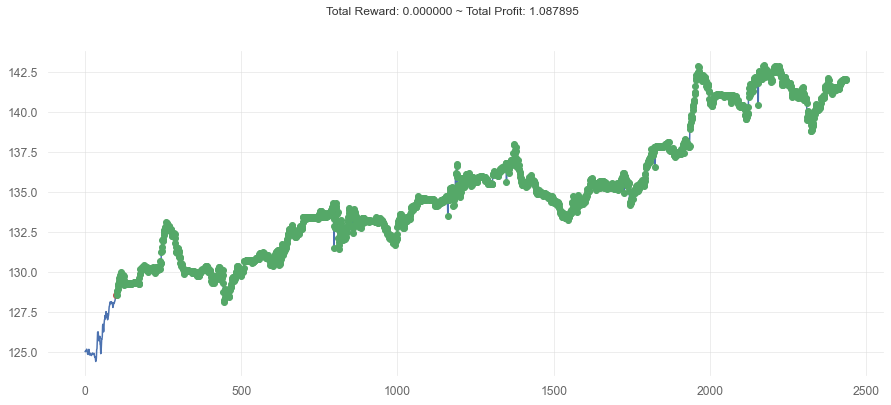

In [25]:
#Plot the results
plt.figure(figsize=(15,6),facecolor='w')
plt.cla()
env.render_all()
plt.show()

# Quant Reports

C:\Users\evere\anaconda3\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\evere\anaconda3\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\evere\anaconda3\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\evere\anaconda3\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


                           Strategy
-------------------------  ----------
Start Period               2023-01-06
End Period                 2023-01-25
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          8.79%
CAGR﹪                     404.49%

Sharpe                     0.33
Prob. Sharpe Ratio         97.72%
Smart Sharpe               -
Sortino                    -
Smart Sortino              -
Sortino/√2                 -
Smart Sortino/√2           -
Omega                      -

Max Drawdown               %
Longest DD Days            -
Volatility (ann.)          2.89%
Calmar                     -
Skew                       48.32
Kurtosis                   2335.0

Expected Daily %           0.0%
Expected Monthly %         8.79%
Expected Yearly %          8.79%
Kelly Criterion            -
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.3%
Expected Shortfall (cVaR)  -0.3%

Max Consecutive Wins       1
Max Consecutive Losses     0
Gain

C:\Users\evere\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\evere\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


None

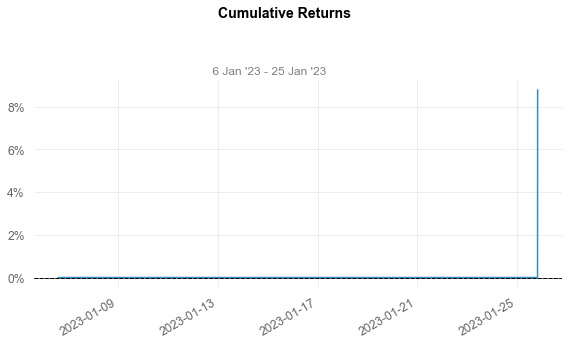

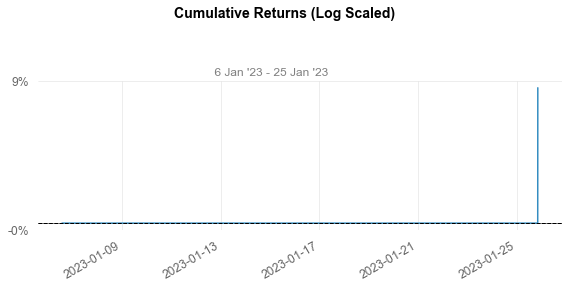

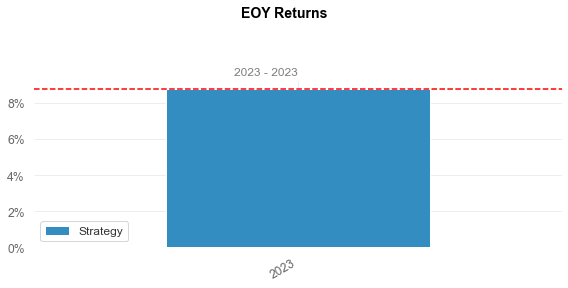

C:\Users\evere\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


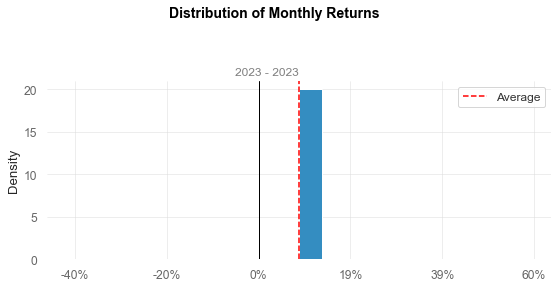

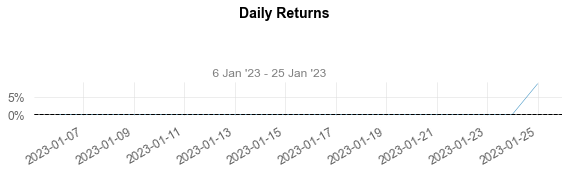

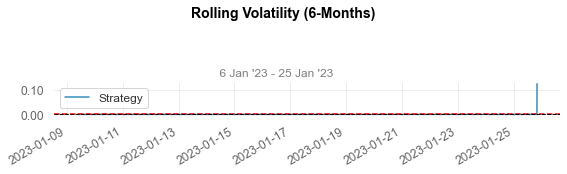

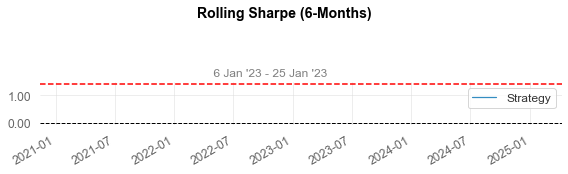

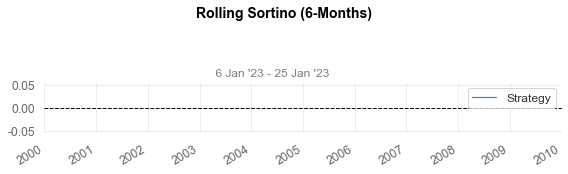

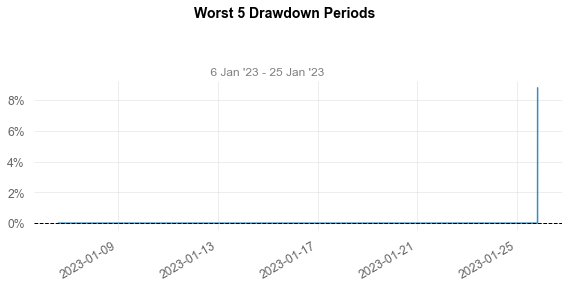

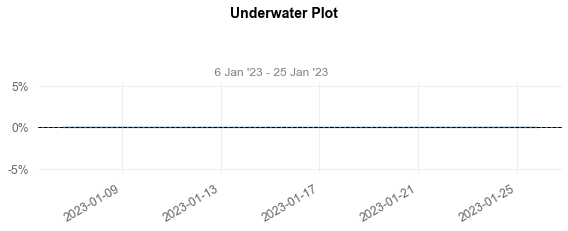

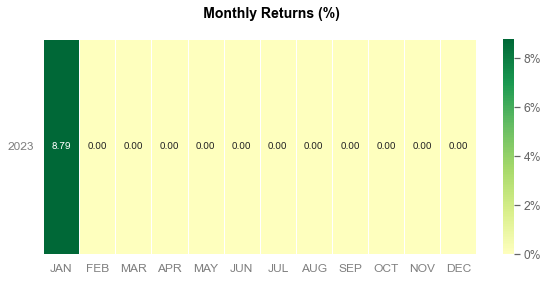

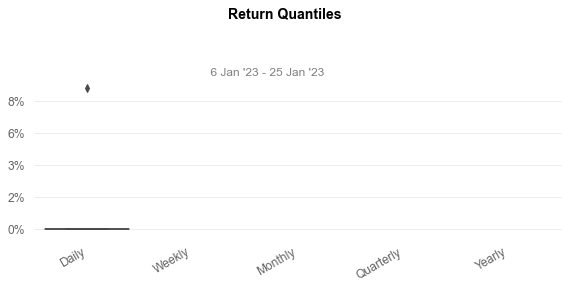

In [26]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[8900+1:])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

# Future Improvements

* ~~Create custom indicators for actions~~
* ~~Create a callback function to stop and save best training weights~~
* ~~Import a larger dataset for a longer period of time~~
* Try different RL Models like DQN or PPO
* ~~Bring in some quantstats to evaluate the performance better~~